In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo
from matplotlib import colormaps

In [11]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [12]:
num_particles = 1000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [13]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [15]:
line.build_tracker(_context=context)
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2361011034682247m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.4451512317969801


In [16]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu())

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/3851 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.816e-06 per turn.
The bucket height is 0.004745, so this implies the sweep will shift one bucket every 3369.99 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.


In [28]:
mean = {'monitor1' : [], 'monitor2' : [], 'monitor3' : []}
std_pos = {'monitor1' : [], 'monitor2' : [], 'monitor3' : []}
std = {'monitor1' : [], 'monitor2' : [], 'monitor3' : []}
std_neg = {'monitor1' : [], 'monitor2' : [], 'monitor3' : []}

for turn in range(num_turns):
    mean['monitor1'].append(np.mean(monitor1.x[:, turn][monitor1.state[:, turn]==1]))
    mean['monitor2'].append(np.mean(monitor2.x[:, turn][monitor2.state[:, turn]==1]))
    mean['monitor3'].append(np.mean(monitor3.x[:, turn][monitor3.state[:, turn]==1]))

    std_pos['monitor1'].append(np.std(monitor1.x[:, turn][(monitor1.x[:, turn]>=mean['monitor1'][-1]) & (monitor1.state[:, turn]==1)]))
    std_pos['monitor2'].append(np.std(monitor2.x[:, turn][(monitor2.x[:, turn]>=mean['monitor2'][-1]) & (monitor2.state[:, turn]==1)]))
    std_pos['monitor3'].append(np.std(monitor3.x[:, turn][(monitor3.x[:, turn]>=mean['monitor3'][-1]) & (monitor3.state[:, turn]==1)]))

    std_neg['monitor1'].append(np.std(monitor1.x[:, turn][(monitor1.x[:, turn]<mean['monitor1'][-1]) & (monitor1.state[:, turn]==1)]))
    std_neg['monitor2'].append(np.std(monitor2.x[:, turn][(monitor2.x[:, turn]<mean['monitor2'][-1]) & (monitor2.state[:, turn]==1)]))
    std_neg['monitor3'].append(np.std(monitor3.x[:, turn][(monitor3.x[:, turn]<mean['monitor3'][-1]) & (monitor3.state[:, turn]==1)]))

    std['monitor1'].append(np.std(monitor1.x[:, turn][monitor1.state[:, turn]==1]))
    std['monitor2'].append(np.std(monitor2.x[:, turn][monitor2.state[:, turn]==1]))
    std['monitor3'].append(np.std(monitor3.x[:, turn][monitor3.state[:, turn]==1]))

# Monitor 1 - QD.31110

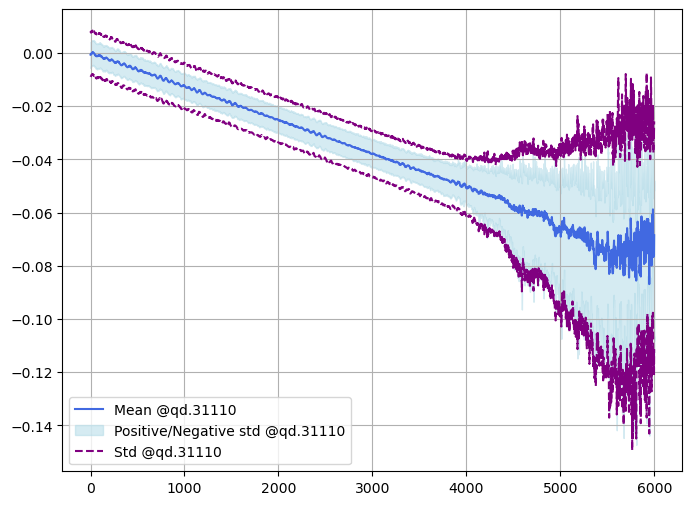

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(range(num_turns), mean['monitor1'], label='Mean @qd.31110', color='royalblue')
ax.fill_between(range(num_turns), np.array(mean['monitor1']) - np.array(std_neg['monitor1']),
                 np.array(mean['monitor1']) + np.array(std_pos['monitor1']),
                 color='lightblue', alpha=0.5, label='Positive/Negative std @qd.31110')
ax.plot(range(num_turns), mean['monitor1']-np.array(std['monitor1']), linestyle='--', color='purple', label='Std @qd.31110')
ax.plot(range(num_turns), mean['monitor1']+np.array(std['monitor1']), linestyle='--', color='purple', label=None)

ax.grid()
ax.legend()

In [59]:
dead_turn = []
for part in range(1000):
    if len(np.where(monitor1.state[part,:]< 1)[0]) > 0:
        dead_turn.append(np.where(monitor1.state[part,:]< 1)[0][0])
    else:
        dead_turn.append(num_turns)

In [64]:
np.mean(dead_turn) + np.std(dead_turn)

np.float64(5632.856257059755)

In [88]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [89]:
df_to_delta(np.min(dead_turn) * sweep_per_turn)

np.float64(-0.011019684442417613)

In [90]:
np.argmin(dead_turn)

np.int64(694)

In [92]:
monitor1.at_element[694]

array([1483, 1483, 1483, ...,    0,    0,    0], shape=(6000,))

In [101]:
np.min(monitor3.x[:,0]) + -0.08784233479197147

np.float64(-0.12412255976306291)

In [97]:
-0.011019684442417613*np.max(tw.dx), -0.011019684442417613*np.min(tw.dx)

(np.float64(-0.08784233479197147), np.float64(0.011263814278932385))

# Monitor 2 - QF.31010

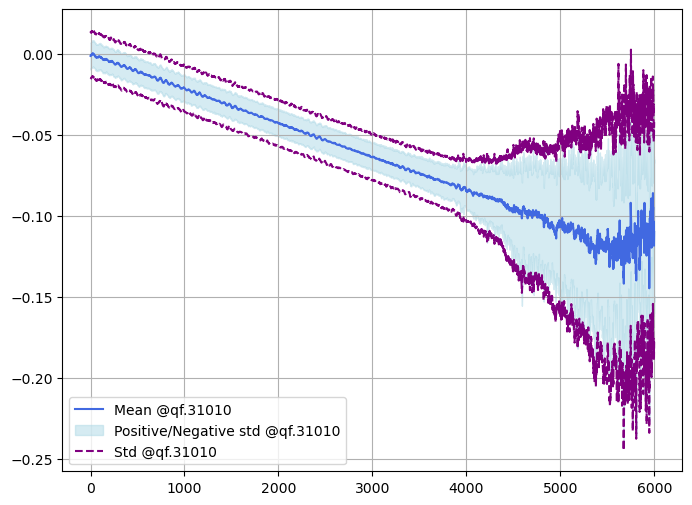

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(range(num_turns), mean['monitor2'], label='Mean @qf.31010', color='royalblue')
ax.fill_between(range(num_turns), np.array(mean['monitor2']) - np.array(std_neg['monitor2']),
                 np.array(mean['monitor2']) + np.array(std_pos['monitor2']),
                 color='lightblue', alpha=0.5, label='Positive/Negative std @qf.31010')
ax.plot(range(num_turns), mean['monitor2']-np.array(std['monitor2']), linestyle='--', color='purple', label='Std @qf.31010')
ax.plot(range(num_turns), mean['monitor2']+np.array(std['monitor2']), linestyle='--', color='purple', label=None)

ax.grid()
ax.legend()

# Monitor 3 - Start of SPS line

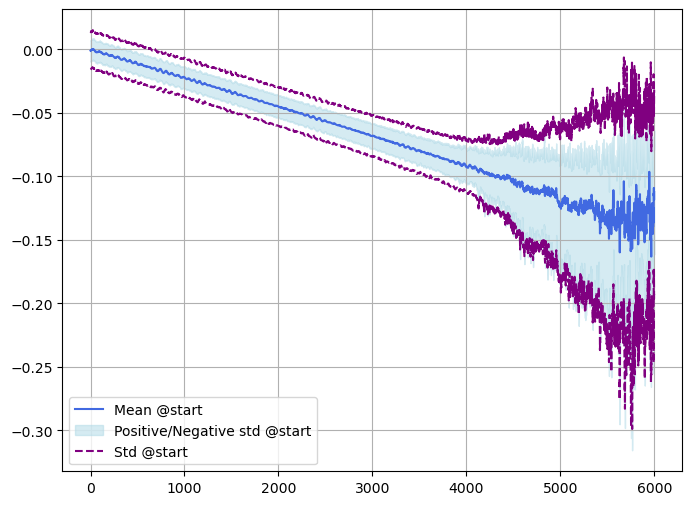

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(range(num_turns), mean['monitor3'], label='Mean @start', color='royalblue')
ax.fill_between(range(num_turns), np.array(mean['monitor3']) - np.array(std_neg['monitor3']),
                 np.array(mean['monitor3']) + np.array(std_pos['monitor3']),
                 color='lightblue', alpha=0.5, label='Positive/Negative std @start')
ax.plot(range(num_turns), mean['monitor3']-np.array(std['monitor3']), linestyle='--', color='purple', label='Std @start')
ax.plot(range(num_turns), mean['monitor3']+np.array(std['monitor3']), linestyle='--', color='purple', label=None)

ax.grid()
ax.legend()

# Phase space plots

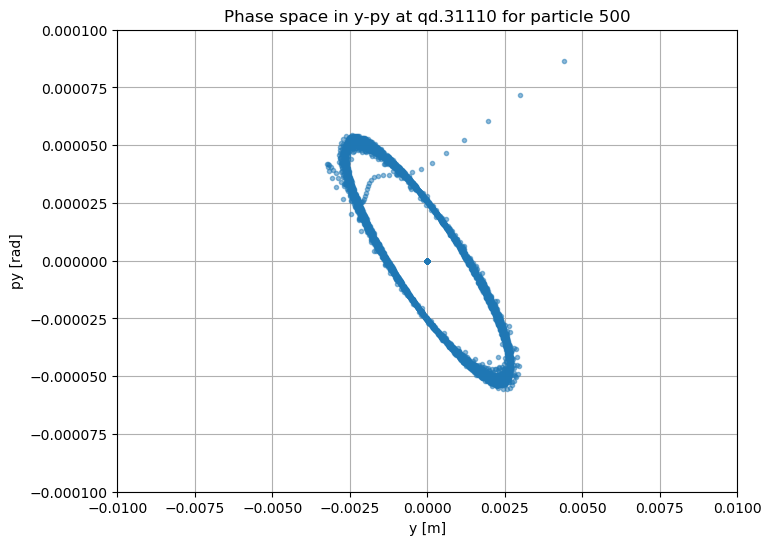

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=500

ax.plot(monitor1.y[pid, :]  , monitor1.py[pid, :], '.', alpha=0.5)
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(-0.0001, 0.0001)
ax.set_xlabel('y [m]')
ax.set_ylabel('py [rad]')
ax.set_title('Phase space in y-py at qd.31110 for particle {}'.format(pid))
ax.grid()

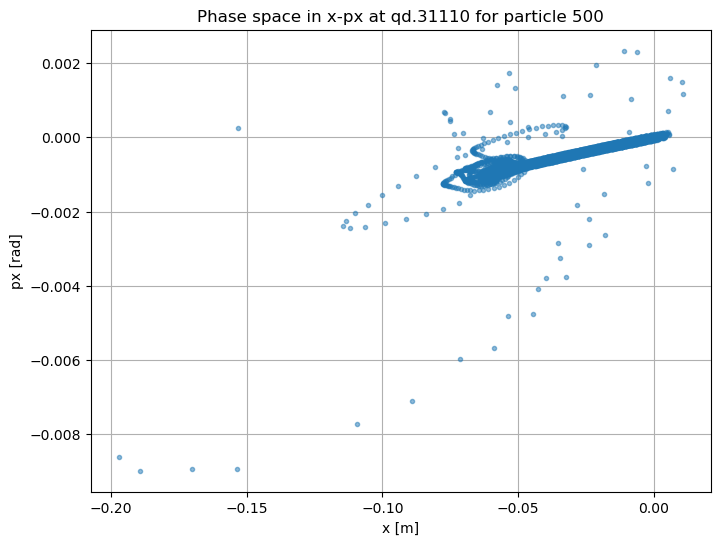

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=500

ax.plot(monitor1.x[pid, :]  , monitor1.px[pid, :], '.', alpha=0.5)
# ax.set_xlim(-0.1, -0.05)
# ax.set_ylim(-0.0001, 0.0001)
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')
ax.set_title('Phase space in x-px at qd.31110 for particle {}'.format(pid))
ax.grid()

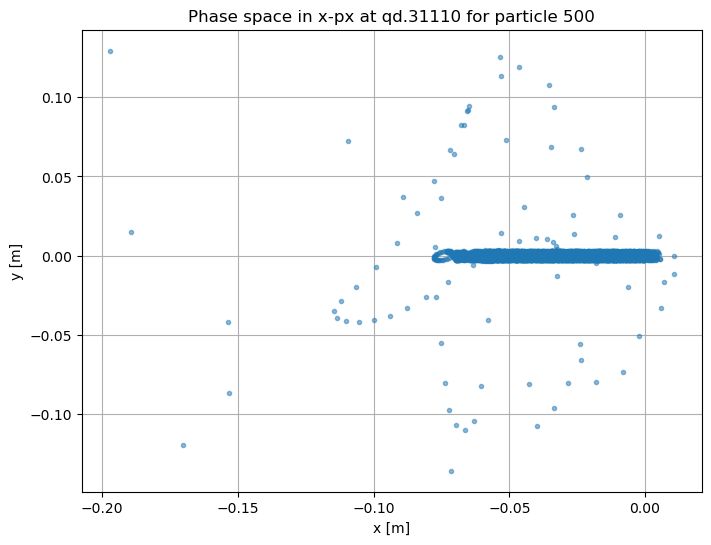

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

cmap = colormaps['YlOrRd']
pid=500

ax.plot(monitor1.x[pid, :]  , monitor1.y[pid, :], '.', alpha=0.5)
# ax.set_xlim(-0.1, -0.05)
# ax.set_ylim(-0.0001, 0.0001)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Phase space in x-px at qd.31110 for particle {}'.format(pid))
ax.grid()

In [84]:
90/20

4.5